<a href="https://colab.research.google.com/github/TaraRasti/Deep_Learning_F20_Assignments/blob/master/Assignment%209/cnn_model_1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os, math, random, time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import torch.nn as nn
import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from collections import defaultdict

In [ ]:
def timer_start():
    global t0
    t0 = time.time()
    
def timer_end():   
    print('Time elapsed {:0.1f}s'.format(time.time() - t0))  

def display_grid(data, path, w =10, h =10, columns = 4, rows = 5):
    fig=plt.figure(figsize=(12, 8))
    for i in range(1, columns*rows +1):
        file = data[i]
        file = os.path.join(path, file)
        img = Image.open(file)
        fig.add_subplot(rows, columns, i)
        imshow(img)
    plt.show()
    
def get_best_epcoh(history):
    valid_acc = history['val_acc']
    best_epoch = valid_acc.index(max(valid_acc)) +1
    best_acc =  max(valid_acc)
    print('Best Validation Accuracy Score {:0.5f}, is for epoch {}'.format( best_acc, best_epoch))
    return best_epoch

def plot_results(history):
    tr_acc = history['tr_acc']
    val_acc = history['val_acc']
    tr_loss = history['tr_loss']
    val_loss = history['val_loss']
    epochs = history['epoch']

    plt.figure(figsize = (24, 6))
    plt.subplot(1,2,1)
    plt.plot(epochs, tr_acc, 'b', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')  
    
    plt.subplot(1,2,2)
    plt.plot(epochs, tr_loss, 'b', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()
    
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    
def online_mean_and_sd(loader):
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)
    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)

        cnt += nb_pixels

    return fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)


In [ ]:
base_dir = '/kaggle/input/cars-wagonr-swift/data/'
train_swift = os.listdir(os.path.join(base_dir, 'train/swift') )
val_swift  = os.listdir(os.path.join(base_dir, 'validation/swift') )
test_swift  =  os.listdir(os.path.join(base_dir, 'test/swift') )
print('Instances for Class Swift: Train {}, Validation {} Test {}'.format(len(train_swift), len(val_swift), len(test_swift)))

Instances for Class Swift: Train 1200, Validation 400 Test 400


In [ ]:
val_train = [x for x in val_swift if x in train_swift]
test_train = [x for x in test_swift if x in train_swift]
val_test =  [x for x in test_swift if x in val_swift]
len(val_train), len(test_train), len(val_test)

(0, 0, 0)

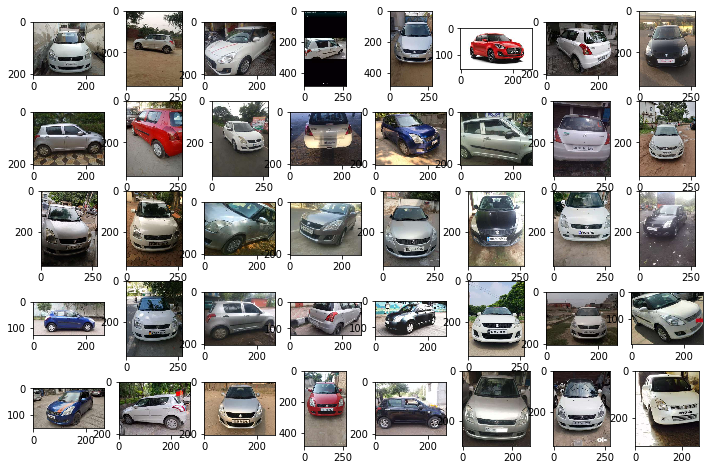

In [ ]:
display_grid(data = train_swift, path = os.path.join(base_dir, 'train/swift'), w =10, h =10, columns = 8, rows = 5)

In [ ]:
train_wr = os.listdir(os.path.join(base_dir, 'train/wagonr') )
val_wr  = os.listdir(os.path.join(base_dir, 'validation/wagonr') )
test_wr  =  os.listdir(os.path.join(base_dir, 'test/wagonr') )
print('Instances for Class Wagonr: Train {}, Validation {} Test {}'.format(len(train_swift), len(val_swift), len(test_swift)))

Instances for Class Wagonr: Train 1200, Validation 400 Test 400


In [ ]:
val_train = [x for x in val_wr if x in train_wr]
test_train = [x for x in test_wr if x in train_wr]
val_test =  [x for x in test_wr if x in val_wr]
len(val_train), len(test_train), len(val_test)

(0, 0, 0)

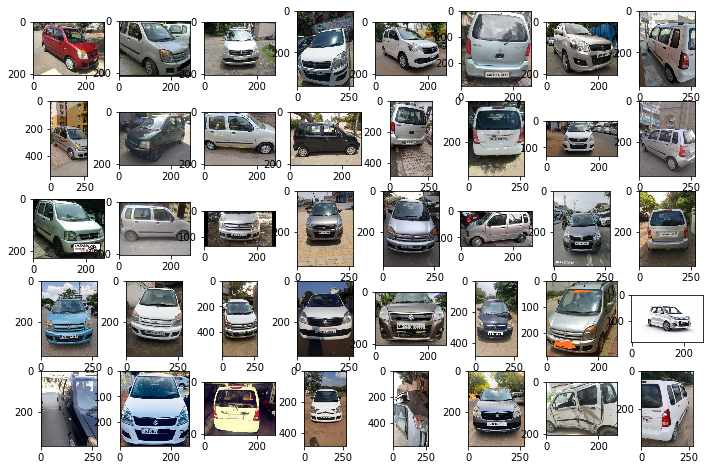

In [ ]:
display_grid(data = train_wr, path = os.path.join(base_dir, 'train/wagonr'), w =10, h =10, columns = 8, rows = 5)

In [ ]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation' )

transform = transforms.Compose( [                                  
                                 transforms.Resize((150,150)), 
                                 transforms.ToTensor(),
                                  ])

trainset = torchvision.datasets.ImageFolder( root= train_dir ,
                                              transform=transform
                                               )

trainloader = torch.utils.data.DataLoader(trainset, batch_size= 512 ,
                                          shuffle=True, num_workers=1)
mean, std = online_mean_and_sd(trainloader)
print(mean, std)

tensor([0.4508, 0.4365, 0.4216]) tensor([0.2561, 0.2542, 0.2592])


In [ ]:
BATCH_SIZE = 32
transform = transforms.Compose( [                                  
                                 transforms.Resize((150,150)), 
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean, std),
                                  ])

trainset = torchvision.datasets.ImageFolder( root= train_dir ,
                                              transform=transform
                                               )


trainloader = torch.utils.data.DataLoader(trainset, batch_size= BATCH_SIZE,
                                          shuffle=True, num_workers=1)


validset = torchvision.datasets.ImageFolder( root= validation_dir ,
                                              transform=transform
                                               )


validloader = torch.utils.data.DataLoader(validset , batch_size= BATCH_SIZE,
                                          shuffle=True, num_workers=1)

print(online_mean_and_sd(trainloader))

(tensor([ 1.3911e-06,  1.1194e-06, -1.1907e-07]), tensor([1.0000, 1.0000, 1.0000]))


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels= 3, out_channels=32, kernel_size= 3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride= 2)
        
        self.conv2 =  nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size= 3)
        self.conv3 =  nn.Conv2d(in_channels= 64, out_channels= 128, kernel_size= 3)
        self.conv4 =  nn.Conv2d(in_channels= 128, out_channels= 128, kernel_size= 3)

        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 2)
       

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 128 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
       
        return x

In [ ]:
def train(model, epoch, train_loader, optimizer, criterion) :   
    model.train()
    epoch_loss = correct = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)    
        optimizer.zero_grad()
        outputs = model(inputs)


        loss =  criterion(outputs, labels)
        

        _, predicted = torch.max(outputs.data, 1)           


        correct += (predicted == labels).sum().item()  

        loss.backward()

        optimizer.step() 
        
        epoch_loss += outputs.shape[0] * loss.item()
        
    accuracy = correct / len(train_loader.dataset)
    epoch_loss = epoch_loss / len(train_loader.dataset)
    return epoch_loss, accuracy


def test(model, epoch, test_loader, optimizer, criterion):
    model.eval()
    epoch_loss = correct = 0

    with torch.no_grad():

        for i, data in enumerate(test_loader, 0):
            images, labels = data[0].to(device), data[1].to(device)

            outputs = model(images)


            loss =    criterion(outputs, labels)


            _, predicted = torch.max(outputs.data, 1)           
            correct += (predicted == labels).sum().item()  


            epoch_loss += outputs.shape[0] * loss.item()

    
    accuracy = correct / len(test_loader.dataset)
    epoch_loss = epoch_loss / len(test_loader.dataset)
  
    return epoch_loss, accuracy 

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net()
model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)
print('Divice: ',device)
model


Divice:  cuda:0


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [ ]:
%%time
EPOCHS = 30


train_list  = os.listdir(os.path.join(base_dir, 'train/swift') ) + os.listdir(os.path.join(base_dir, 'train/wagonr') )
num_batches = math.ceil(len(train_list) / BATCH_SIZE)

print('Number of Training samples {}, Batch Size {}, Num Batch {}'.format( len(train_list), BATCH_SIZE, num_batches ))

history = defaultdict(list)


for epoch in range( EPOCHS):  
    timer_start()
    print('[Epoch {} of {}]'.format(epoch +1, EPOCHS), end = ' ')
    tr_loss, tr_acc = train(model, epoch, trainloader, optimizer, criterion)

    val_loss, val_acc = test(model, epoch, validloader, optimizer, criterion)  
    timer_end()
    print('tr_loss: {:0.4f},tr_acc {:0.4f}| val_loss {:0.4f}, val_acc {:0.4f}'.format(tr_loss, tr_acc , val_loss, val_acc))
    history['epoch'].append(epoch+1)
    history['tr_loss'].append(round(tr_loss,5))
    history['tr_acc'].append(round(tr_acc,5))
    history['val_loss'].append(round(val_loss,5))
    history['val_acc'].append(round(val_acc,5))


Number of Training samples 2400, Batch Size 32, Num Batch 75
[Epoch 1 of 30] Time elapsed 15.4s
tr_loss: 0.6736,tr_acc 0.5850| val_loss 0.6347, val_acc 0.6212
[Epoch 2 of 30] Time elapsed 16.8s
tr_loss: 0.5860,tr_acc 0.6892| val_loss 0.5254, val_acc 0.7388
[Epoch 3 of 30] Time elapsed 13.9s
tr_loss: 0.4717,tr_acc 0.7762| val_loss 0.4434, val_acc 0.7812
[Epoch 4 of 30] Time elapsed 16.2s
tr_loss: 0.3840,tr_acc 0.8275| val_loss 0.3932, val_acc 0.8213
[Epoch 5 of 30] Time elapsed 14.7s
tr_loss: 0.3312,tr_acc 0.8608| val_loss 0.3747, val_acc 0.8400
[Epoch 6 of 30] Time elapsed 14.2s
tr_loss: 0.2894,tr_acc 0.8800| val_loss 0.3582, val_acc 0.8400
[Epoch 7 of 30] Time elapsed 19.3s
tr_loss: 0.2521,tr_acc 0.8983| val_loss 0.3418, val_acc 0.8512
[Epoch 8 of 30] Time elapsed 13.4s
tr_loss: 0.2268,tr_acc 0.9129| val_loss 0.3420, val_acc 0.8462
[Epoch 9 of 30] Time elapsed 13.7s
tr_loss: 0.1926,tr_acc 0.9258| val_loss 0.3454, val_acc 0.8475
[Epoch 10 of 30] Time elapsed 14.2s
tr_loss: 0.1663,tr_ac

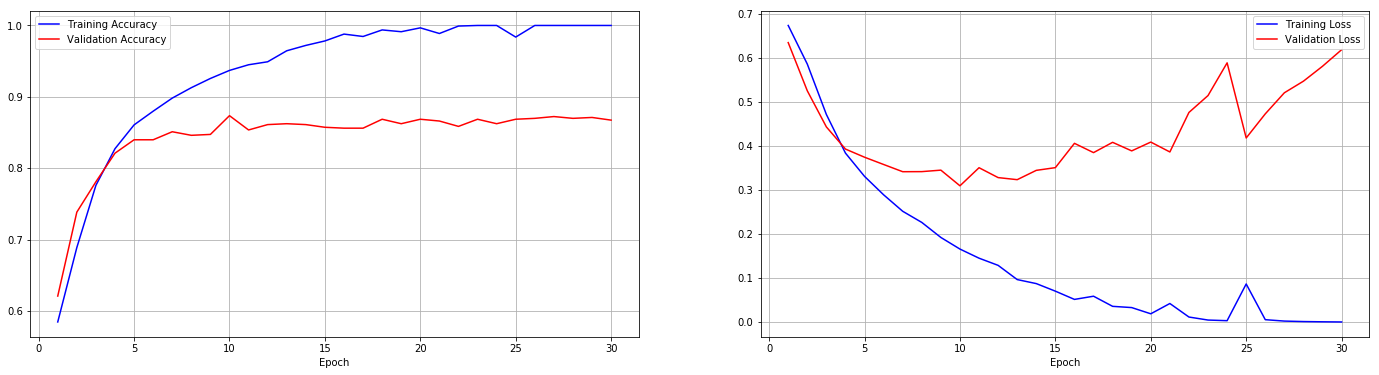

Best Validation Accuracy Score 0.87375, is for epoch 10


In [ ]:
plot_results(history)
best_epoch = get_best_epcoh(history)